In [1]:
import numpy as np
import matplotlib.pylab as plt
from library import *
from tqdm import tqdm

The Langevin equation is a stochastic differential equation that incorporates deterministic forces (such as those derived from a potential energy function) and stochastic forces that represent random fluctuations due to thermal energy. The equation is given by:

`m * dv/dt = -γ * v + η(t) + F`

where:
- `m` is the mass of the particle,
- `v` is the velocity of the particle,
- `γ` is the friction coefficient,
- `η(t)` is a Gaussian white noise term with zero mean and unit variance, representing the random forces,
- `F` is the deterministic force derived from the potential energy.

The Langevin equation is often used in molecular dynamics simulations to model the interaction of a small system with a heat bath. The friction term `-γ * v` represents energy dissipation to the bath, while the random force `η(t)` represents energy input from the bath, ensuring that the system remains at a constant temperature.

The Langevin dynamics approach provides a more realistic model for many systems than Newtonian dynamics, as it naturally incorporates temperature effects and allows for the exploration of thermodynamic properties.

Here, this equation is solved for free particles , that are not interacting with any potential . it is solved with both periodic boundary conditions and box boundary conditions.


In [2]:
"""declaring global constants"""
avogadro = 6.02214086e23
boltzmann = 1.38064852e-23
ndim = 3

The `RunSimulation` function is the main driver of the simulation. It initializes the simulation parameters, runs the simulation for a specified number of steps, and logs the output. Here's a step-by-step explanation:

## Reflective Boundary condition

In [3]:
def RunSimulation():
    """ Takes in input the parameters of a the simulation, calls the initialization function, 
    and calls the force-computing, position-velocities updating and buondary enforcement 
    functions until the max number of steps is reached, returning an array made from timestep
    and temperature calculated at each step.
    returns output: array with (timestep*step, Temperature) (2,natoms)
    """
    # Define the parameters
    natoms = 100
    temp = 300
    mass = 1.0
    dt = 0.01
    maxSteps = 1000
    box = np.array([[0, 10], [0, 10], [0, 10]])
    relax = 0.5
    
    output = []
    """setting the mass as the molecular mass"""
    mass = mass/avogadro
    
    """Initializing the velocities and the positions"""
    positions, velocities = CoordInitialitation(box, natoms, ndim)

    """initializing the arrays for the evolution of the energy and the temperature"""
    time_steps = np.zeros(maxSteps)
    energy_evolve = np.zeros(maxSteps) 
    temp_evolve = np.zeros(maxSteps)
    velAutCorr = np.zeros(maxSteps)
    velocities_list = []

    """starting the iteration"""
    for step in tqdm(range(maxSteps)):
        
        """calculating the forces"""
        forces = CalculateForces(velocities, relax, mass, temp, dt)
        
        """integrating"""
        MotionIntegration(positions, velocities, forces, mass, dt)
        
        """applying reflective boundaries"""
        EnforceWallReflection(positions, velocities, box)

        """storing the parameters for the evolution of the system"""
        total_energy = CalculateTotalEnergy(velocities, forces, positions, mass)
        energy_evolve[step] = total_energy
        time_steps[step] = step
        temp_evolve[step] = ComputeInstTemp(velocities, mass)
        velocities_list.append(velocities.copy())

        output.append([dt*step, ComputeInstTemp(velocities, mass)])
    
    VACF = CalculateVACF(np.array(velocities_list))

    return np.array(output), energy_evolve, temp_evolve, time_steps, VACF

In [4]:
"""runs the simulation"""
output, energy, temp, time_ ,VACF= RunSimulation()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1844.97it/s]


Caculating VACF


100%|██████████| 1000/1000 [00:03<00:00, 324.39it/s]


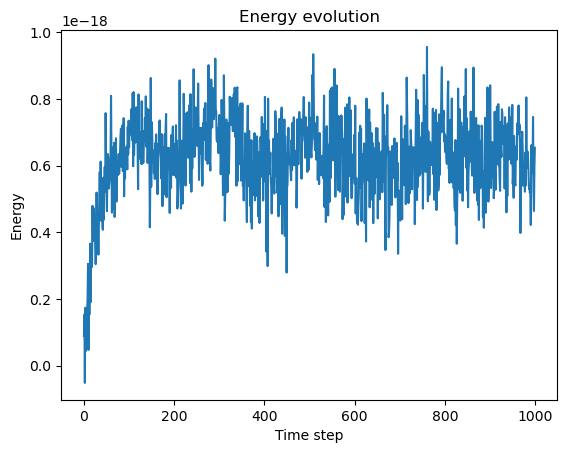

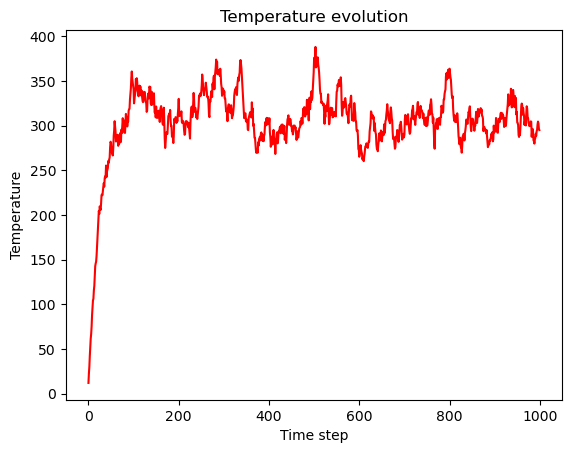

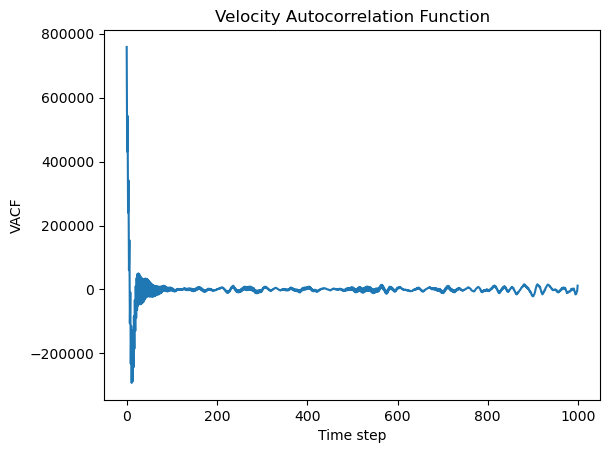

In [5]:
"""plots the energy evolution"""
plt.plot(time_, energy)
plt.xlabel('Time step')
plt.ylabel('Energy')
plt.title('Energy evolution')
plt.show()

"""plots the temperature evolution"""
plt.plot(time_, temp, color='red')
plt.xlabel('Time step')
plt.ylabel('Temperature')
plt.title('Temperature evolution')
plt.show()

# Plot the VACF
plt.plot(VACF)
plt.xlabel('Time step')
plt.ylabel('VACF')
plt.title('Velocity Autocorrelation Function')
plt.show()

## periodic boundaries

In [6]:
def RunSimulation():
    """ Takes in input the parameters of a the simulation, calls the initialization function, 
    and calls the force-computing, position-velocities updating and buondary enforcement 
    functions until the max number of steps is reached, returning an array made from timestep
    and temperature calculated at each step.
    @outputFile: output file name (string)
    returns output: array with (timestep*step, Temperature) (2,natoms)
    """
    # Define the parameters
    natoms = 100
    temp = 300
    mass = 1.0
    radius = 1.0
    dt = 0.01
    maxSteps = 1000
    freq = 10
    box = np.array([[0, 10], [0, 10], [0, 10]])
    relax = 0.5
    
    output = []
    """setting the mass as the molecular mass"""
    mass = mass/avogadro
    
    """Initializing the velocities and the positions"""
    positions, velocities = CoordInitialitation(box, natoms, ndim)

    """initializing the arrays for the evolution of the energy and the temperature"""
    time_steps = np.zeros(maxSteps)
    energy_evolve = np.zeros(maxSteps) 
    temp_evolve = np.zeros(maxSteps)
    velAutCorr = np.zeros(maxSteps)
    velocities_list = []

    """starting the iteration"""
    for step in tqdm(range(maxSteps)):
        
        """calculating the forces"""
        forces = CalculateForces(velocities, relax, mass, temp, dt)
        
        """integrating"""
        MotionIntegration(positions, velocities, forces, mass, dt)
        
        """applying reflective boundaries"""
        EnforcePeriodicBoundary(positions, box)

        """storing the parameters for the evolution of the system"""
        total_energy = CalculateTotalEnergy(velocities, forces, positions, mass)
        energy_evolve[step] = total_energy
        time_steps[step] = step
        temp_evolve[step] = ComputeInstTemp(velocities, mass)
        velocities_list.append(velocities.copy())

        """exporting the output using the output exporting frequency set in the
        config parameters"""
        output.append([dt*step, ComputeInstTemp(velocities, mass)])
    
    VACF = CalculateVACF(np.array(velocities_list))

    return np.array(output), energy_evolve, temp_evolve, time_steps, VACF

In [7]:
"""runs the simulation"""
output, energy, temp, time_ ,VACF= RunSimulation()

100%|██████████| 1000/1000 [00:00<00:00, 2829.07it/s]


Caculating VACF


100%|██████████| 1000/1000 [00:03<00:00, 298.27it/s]


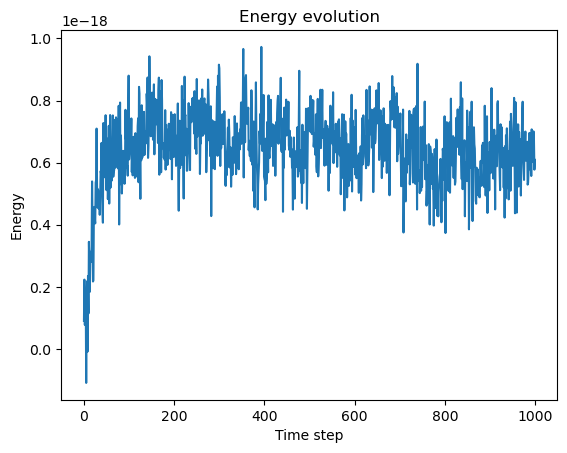

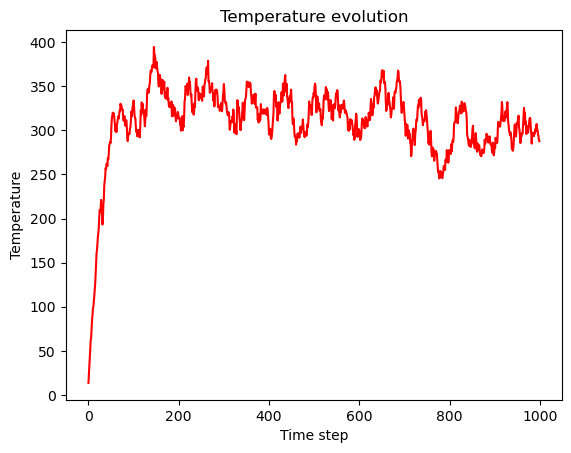

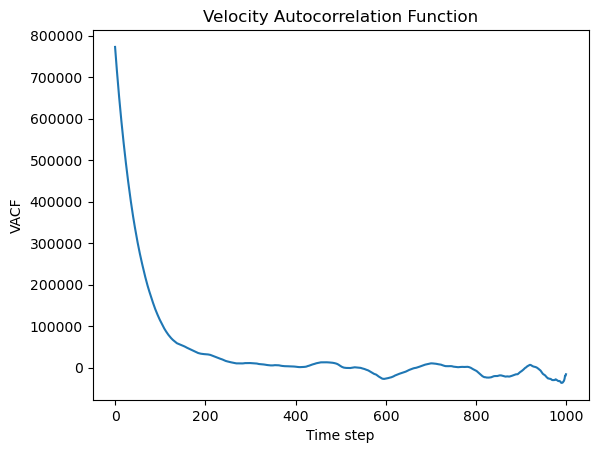

In [8]:
"""plots the energy evolution"""
plt.plot(time_, energy)
plt.xlabel('Time step')
plt.ylabel('Energy')
plt.title('Energy evolution')
plt.show()

"""plots the temperature evolution"""
plt.plot(time_, temp, color='red')
plt.xlabel('Time step')
plt.ylabel('Temperature')
plt.title('Temperature evolution')
plt.show()

# Plot the VACF
plt.plot(VACF)
plt.xlabel('Time step')
plt.ylabel('VACF')
plt.title('Velocity Autocorrelation Function')
plt.show()